# Курсовой проект по курсу Спортивный анализ данных. Платформа Kaggle

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score,roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as st
from sklearn.model_selection import KFold, train_test_split, cross_val_score

import time
warnings.simplefilter("ignore")
%matplotlib inline

#### Загруза данных

In [2]:
train=pd.read_csv('data\\train.csv')
test=pd.read_csv('data\\test.csv')
client_profile=pd.read_csv('data\\client_profile.csv')
app_h = pd.read_csv("data\\applications_history.csv")
payments=pd.read_csv('data\\payments.csv')
bki=pd.read_csv('data\\bki.csv'),


In [3]:
data = pd.concat([train,test], axis=0)
data = data.reset_index(drop=True)

In [4]:
payments['APPLICATION_NUMBER'].value_counts()

123619703    37
123486520    33
123682859    31
123449869    31
123632163    31
             ..
123623862     1
123621815     1
123698858     1
123692713     1
123731968     1
Name: APPLICATION_NUMBER, Length: 264726, dtype: int64

In [5]:
pay_groupby = payments.groupby("APPLICATION_NUMBER", as_index=False)
previous_pay_counts = pay_groupby["PREV_APPLICATION_NUMBER"].count()
previous_pay_counts = previous_pay_counts.rename(columns={
    "PREV_APPLICATION_NUMBER": "PREV_APPS_COUNT"
})
previous_pay_counts.head(n=3)

,APPLICATION_NUMBER,PREV_APPS_COUNT
0,123423340,2
1,123423341,2
2,123423344,1


In [6]:
columns=payments.columns.drop(['APPLICATION_NUMBER'])

In [7]:
data = data.merge(
    pay_groupby[columns].mean(), how="left", on="APPLICATION_NUMBER")
data = data.merge(
    previous_pay_counts, how="left", on="APPLICATION_NUMBER")

In [8]:
client_profile.columns = [col.lower() for col in client_profile.columns]
data.columns = [col.lower() for col in data.columns]

In [9]:
def create_client_profile_features(X: pd.DataFrame) -> pd.DataFrame:
   
    X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
  

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

In [10]:
data = data.merge(
    create_client_profile_features(client_profile), how="left", on="application_number"
)

In [14]:
apps = pd.read_csv("data\\applications_history.csv")
apps.head(n=2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [15]:
apps_groupby = apps.groupby("APPLICATION_NUMBER", as_index=False)
previous_app_counts = apps_groupby["PREV_APPLICATION_NUMBER"].count()
previous_app_counts = previous_app_counts.rename(columns={
    "PREV_APPLICATION_NUMBER": "PREV_APPS_COUNT"
})
previous_app_counts.head(n=3)

,APPLICATION_NUMBER,PREV_APPS_COUNT
0,123423340,1
1,123423341,1
2,123423342,3


#### Разбиение train test

In [16]:
tr=data['target']
data.drop('target',inplace=True,axis=1)
data.fillna(-9999999,inplace=True)
data['target']=tr

In [17]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [19]:
x_train, x_valid = train_test_split(
      train, train_size=0.7, random_state=27
    )
y_train, y_valid = train_test_split(
        target, train_size=0.7, random_state=27
    )


x_valid[categorial] = x_valid[categorial].astype(str)
x_train[categorial] = x_train[categorial].astype(str)
test[categorial] = test[categorial].astype(str)

cb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 1000,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
   
}
model_catboost = cb.CatBoostClassifier(**cb_params)
       
model_catboost.fit(x_train, y_train,cat_features=categorial,eval_set=[(x_train, y_train), (x_valid, y_valid)])
oof_preds_catboost= model_catboost.predict_proba(x_valid)[:, 1]
oof_preds_train_catboost=model_catboost.predict_proba(x_train)[:, 1]

0:	test: 0.5881468	test1: 0.5864017	best: 0.5864017 (0)	total: 137ms	remaining: 6m 52s
1000:	test: 0.7474232	test1: 0.7307314	best: 0.7307502 (996)	total: 2m 23s	remaining: 4m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7324266805
bestIteration = 1428

Shrink model to first 1429 iterations.


#### Важность признаков

In [20]:
import shap
shap.initjs()

In [21]:
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer.shap_values(x_train)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

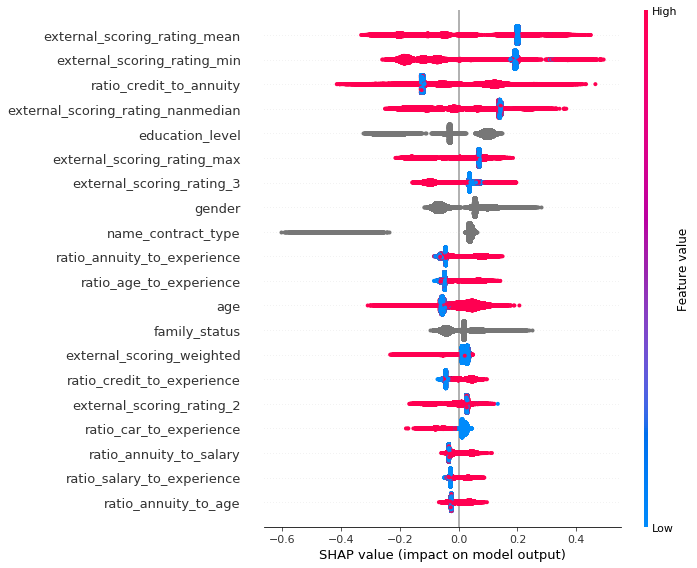

In [22]:
shap.summary_plot(shap_values, x_train)

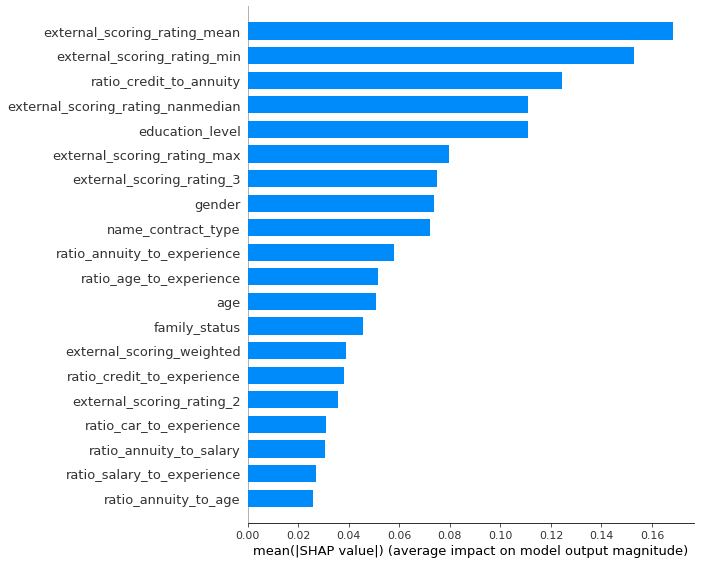

In [23]:
shap.summary_plot(shap_values, x_train, plot_type="bar",show=all)

In [24]:
shap_sum = (shap_values).mean(axis=0)
importance_df = pd.DataFrame([train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df=importance_df[importance_df['shap_importance']!=0]

In [25]:
feuturs=importance_df['column_name']

#### Обучение Catboost, Lgbm, xgBoost.

In [26]:
x_train, x_valid = train_test_split(
      train[feuturs], train_size=0.7, random_state=42
    )
y_train, y_valid = train_test_split(
        target, train_size=0.7, random_state=42
    )

categorial = x_train.dtypes[train.dtypes == "object"].index
x_valid[categorial] = x_valid[categorial].astype(str)
x_train[categorial] = x_train[categorial].astype(str)
test[categorial] = test[categorial].astype(str)

cb_params = {
    "n_estimators": 6000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
 #   "task_type": "CPU",
    "max_bin": 20,
    "verbose": 1000,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
   
}
model_catboost = cb.CatBoostClassifier(**cb_params)
       
model_catboost.fit(x_train, y_train,cat_features=categorial,eval_set=[(x_train, y_train), (x_valid, y_valid)])
oof_preds_catboost= model_catboost.predict_proba(x_valid)[:, 1]
oof_preds_train_catboost=model_catboost.predict_proba(x_train)[:, 1]

0:	test: 0.6391877	test1: 0.6463484	best: 0.6463484 (0)	total: 223ms	remaining: 22m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7317412139
bestIteration = 932

Shrink model to first 933 iterations.


In [31]:
train_lgbm=train[feuturs].copy()
for column in categorial:
    dummy=pd.get_dummies(train_lgbm[column])
    for i in dummy:
        train_lgbm[i]=dummy[i]
train_lgbm.drop(categorial,axis=1,inplace=True)                   

In [49]:
x_train, x_valid = train_test_split(
      train_lgbm, train_size=0.7, random_state=27
    )
y_train, y_valid = train_test_split(
  target, train_size=0.7, random_state=27
    )

model_lgbm = lgb.LGBMClassifier(n_estimators =6000,
                                max_depth=6,
                                l2_leaf_reg=20,
                                early_stopping_rounds=50,
                                random_seed=42,
                                 )       
model_lgbm.fit(x_train, y_train,eval_set=[(x_train, y_train), (x_valid, y_valid)],eval_metric ='auc',verbose=1000)
oof_preds_lgbm= model_lgbm.predict_proba(x_valid)[:, 1]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	training's auc: 0.831391	training's binary_logloss: 0.223943	valid_1's auc: 0.731838	valid_1's binary_logloss: 0.255102


In [50]:
score = roc_auc_score(y_valid, oof_preds_lgbm)
score

0.7318379146029698

In [190]:
x_train, x_valid = train_test_split(
      train_lgbm, train_size=0.7, random_state=27
    )
y_train, y_valid = train_test_split(
        target, train_size=0.7, random_state=27)

model_xgb = xgb.XGBClassifier(n_estimators =2000,
                                max_depth=6,
                                random_state =42,
                                min_child_weight=100
                                )
                                                             
       
model_xgb.fit(x_train, y_train,eval_set=[(x_train, y_train), (x_valid, y_valid)],
              eval_metric ='auc',verbose=1000,early_stopping_rounds=20)
oof_preds_xgb= model_xgb.predict_proba(x_valid)[:, 1]

[0]	validation_0-auc:0.70926	validation_1-auc:0.70029
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
Stopping. Best iteration:
[20]	validation_0-auc:0.75976	validation_1-auc:0.72830



In [191]:
score = roc_auc_score(y_valid, oof_preds_xgb)
score

0.7282992376471281

In [208]:
oof=pd.DataFrame(oof_preds_xgb,columns=['xgb'])
oof['cb']=oof_preds_catboost
oof['lgbm']=oof_preds_lgbm



#### Усреднение результата по трем моделям

In [209]:
from scipy.stats.mstats import gmean

oof['gmean'] = gmean(oof.iloc[:,:3],axis=1)
oof['mean'] = np.mean(oof.iloc[:,:3],axis=1)


In [211]:
score = roc_auc_score(y_valid, oof['gmean'])
score

0.7333750020073652

In [212]:
test_dummy=test[feuturs].copy()
for column in categorial:
    dummy=pd.get_dummies(test_dummy[column])
    for i in dummy:
        test_dummy[i]=dummy[i]
test_dummy.drop(categorial,axis=1,inplace=True)  

In [213]:
test_dummy=test_dummy.fillna(-9999)

#### Вывод данных

In [214]:
oof=pd.DataFrame(model_lgbm.predict_proba(test_dummy)[:, 1],columns=['lgbm'])
oof['xgb']=model_xgb.predict_proba(test_dummy)[:, 1]
oof['cb']=model_catboost.predict_proba(test[feuturs])[:, 1]

In [215]:
oof['gmean'] = gmean(oof.iloc[:,:3],axis=1)

In [216]:
dt=pd.DataFrame(test_id.values,columns=['APPLICATION_NUMBER'])
dt['TARGET']=oof['xgb']

In [201]:
dt.to_csv('submit_1.csv',header=['APPLICATION_NUMBER','TARGET'],index=False)

#### Public Leaderboard 0.72862